In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes/description.pdf
/kaggle/input/diabetes/diabetic_data.csv


# Load data

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('/kaggle/input/diabetes/diabetic_data.csv')

df.columns = df.columns.str.strip()
df = df.replace('?', np.nan)

df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [12]:
# ML imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support
import shap

# Fix categorical columns and create target

In [13]:
# Convert object columns to string and fill missing values
for c in df.select_dtypes(include=['object','string']).columns:
    df[c] = df[c].astype('string').fillna('Unknown')

# Create binary target: 1 if readmitted <30, else 0
df['readmit_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)


In [14]:
#Drop ID columns and define X, y
drop_cols = ['encounter_id', 'patient_nbr', 'readmitted']
X = df.drop(columns = drop_cols + ['readmit_30'])
y = df['readmit_30']


# Train test split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Preprocessing

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

cat_cols = X_train.select_dtypes(include=['string','object']).columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])


# Model (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)



# Evaluation

AUC: 0.6685857494575932


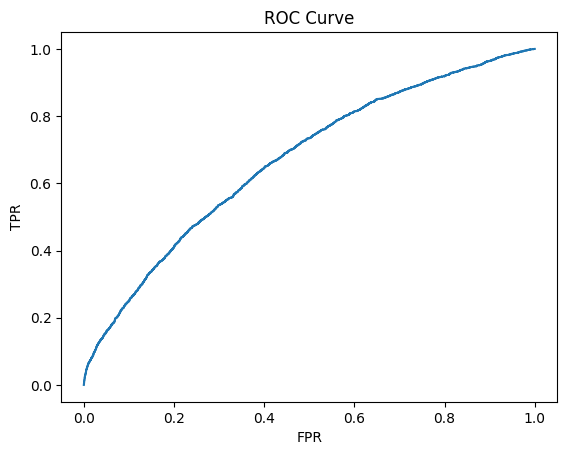

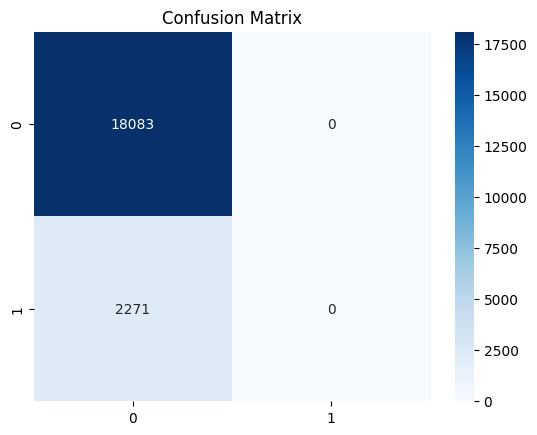

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.00      0.00      0.00      2271

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.84     20354



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# AUC
proba = model.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_test, proba))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, model.predict(X_test)))


--------------------------------------------------------------------------------------------------------------------

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df = pd.read_csv('/kaggle/input/diabetes/diabetic_data.csv')

df = df.drop(['encounter_id', 'patient_nbr'], axis=1)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

y = df['readmitted']
X = df.drop('readmitted', axis=1)

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Gradient Boosting

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

gb = Pipeline([
    ('preprocess', preprocess),
    ('model', GradientBoostingClassifier())
])

gb.fit(X_train, y_train)
proba_gb = gb.predict_proba(X_test)[:,1]
print("Gradient Boosting AUC:", roc_auc_score(y_test, proba_gb))


Gradient Boosting AUC: 0.6699234262824018


> The model achieved an AUC of about 0.67, which is normal for this dataset. This means the prediction of 30 day readmission for diabetic patients is possible but limited by the quality of the data. Gradient Boosting gave moderate performance and can help flag higher risk patients, though better results would require richer clinical information.